In [1]:
cd ..

/home/mars/src_aiai


In [2]:
import pickle
import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from src.visualisation import compare, print_statistics, plot_statistics
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error

In [5]:
import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 2
sns.set_context("notebook", font_scale=1.1)

In [6]:
def compare_multiple(images, ncols=None, nrows=None, titles=None, same_scale=False, colorbar=False, cmap='viridis', save_base="./plots/example", cbar_anchor=1.2, rot=0, vmin=None, vmax=None):
    """[summary]
    TODO add colorbars
    Args:
        images ([type]): [description]
        ncols ([type], optional): [description]. Defaults to None.
        nrows ([type], optional): [description]. Defaults to None.
        titles ([type], optional): [description]. Defaults to None.
        same_scale (bool, optional): [description]. Defaults to False.
    """

    if not nrows:
        nrows = 1
    if not ncols:
        ncols = 1
    if ncols*nrows < len(images):
        ncols = len(images)
        nrows = 1
    if not titles:
        titles = [""]*len(images)
    
    images = [np.rot90(i, rot) for i in images]
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
        figsize=(ncols*6, nrows*6 +1), squeeze=False)

    a = ax[0,0].imshow(images[0])    
    ax[0,0].set_title(titles[0])
    if vmin is None:
        vmin, vmax = a.get_clim()
    for i in range(0, nrows):
        for j in range(ncols):
            if i +j*nrows >= len(images):
                break
            if same_scale:
                im = ax[i,j].imshow(images[j + i*ncols], 
                    vmin=vmin, vmax=vmax, cmap=cmap)
            else:
                im = ax[i,j].imshow(images[j + i*ncols], cmap=cmap)
            if j % ncols != 0:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] + f"\n(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                else:
                    ax[i,j].set_title(f"(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                    
            else:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] +"\n")
                else:
                    ax[i,j].set_title(titles[j + i*ncols])
                    
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
    if colorbar:
        plt.colorbar(im, ax=ax, anchor=(cbar_anchor,0), shrink=.8)
    plt.subplots_adjust(wspace=.01)

In [7]:
data = "COCO"
ISNR = 30

In [8]:
metrics = [
    ("PSNR", peak_signal_noise_ratio),
    ("SSIM", structural_similarity),
    ("MSE", mean_squared_error)
]

In [9]:
results = [
    ("Pseudo-inverse", "PseudoInverse", ""),
    ("Primal-Dual", "PD", ""),
#     ("Primal-Dual2", "PD", "_new_wavelets"),     
    
    ("U-Net", "UNet", ""),
    
#     ("GU-Net", "GUnet", ""),
    ("GU-Net", "GUnet", ""),
#     ("GU-Net", "GUnet", "_fixed_undilution_no_batch_norm"),

#     ("GU-Net", "GUnet", "_undiluted_normal"),
#     ("GU-Net", "GUnet", "_undiluted_filtered"),
    
#     ("GU-Net", "GUnet", "_undiluted2"),
#     ("GU-Net", "GUnet", "_undiluted"),
    
#     ("GU-Net", "GUnet", "_undiluted_nosub"),
    
#     ("HL-Net", "highlow", ""),
]

In [10]:
data = "COCO"


In [11]:
import pandas as pd
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error

metrics = [
    ("PSNR", peak_signal_noise_ratio),
    ("SSIM", structural_similarity),
    ("MSE", mean_squared_error)
]

ISNR = 30
network = "PD"
operator = "NUFFT_SPIDER"
postfix = "_new_wavelets"
data = "COCO"

statistics = pd.DataFrame(columns=["PSNR", "SSIM", "MSE", "method", "set"])
name = f"{network} {operator} {postfix[1:]}"

x_true = np.load(f"./data/intermediate/{data}/{operator}/x_true_train_{ISNR}dB.npy")
train_predict = np.load(f"./data/processed/{data}/{operator}/train_predict_{network}_{ISNR}dB{postfix}.npy")
# x_true_test = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_{ISNR}dB.npy")
# test_predict = np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_{ISNR}dB{postfix}.npy")


for dset, x, pred in [ ("train", x_true, train_predict)]:#,  ("test", x_true_test, test_predict)]:
    df = pd.DataFrame()
    for metric, f in metrics:
        df[metric] = [f(x[i], np.clip(pred[i], 0, 1)) for i in range(len(x))]
        df['Method'] = name
        df['Set'] = dset
        if statistics.empty:
            statistics = df
        else:
            statistics = statistics.append(df, ignore_index=False)

print("saving results")
with pd.option_context('mode.use_inf_as_na', True):
    statistics.dropna(inplace=True)

statistics.to_csv(f"./results/{data}/{operator}/statistics_{network}_{ISNR}dB{postfix}.csv")


saving results


In [12]:

def print_statistics(statistics, results, metrics, latex=False):
    if latex:
        separator = " & "
        lines = ""
    else:
        separator = "|"
        lines = "|"
    

    print( f"{'Name':40}", end=separator)
    for metric, f in metrics:
        print(f"{metric:20}", end=separator)
    if latex:
        print("\\\\", end="")
    print()
    for name, set, _ in sorted(results):
        if name in statistics.Method.values:
            print(f"{name+'_'+set:40}", end=separator)
            for metric, f in metrics:
                if latex:
                    print(f"$ {np.nanmean(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):8.3f} \pm {np.std(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):7.3f} $", end=separator)
                else:
                    print(f"{np.nanmean(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):8.3f} \pm {np.std(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):7.3f}", end=separator)
                
                # median = np.median(statistics[metric][(statistics.Method == name) * (statistics.Set == set)])
                # smad = 1.4826* np.median(np.abs(statistics[metric][(statistics.Method == name) * (statistics.Set == set)] - median))
                # print(f"{median:8.3f} \pm {smad:7.3f}|", end="")
            if latex:
                print("\\\\", end="")
            print()

In [13]:
def plot_statistics(statistics, metrics, ylims=[[0,40], [0,1], [0, 0.04]], split=True, order=None, save_base="./plots/violinplot"):
    #TODO add some better ytick labels, currently to many/much precision
    
    for idx, (metric, _) in enumerate(metrics):
        plt.figure(figsize=(8,6))
        sns.set_style('whitegrid')
        sns.violinplot(data=statistics, x='name', y=metric, split=split, hue='Set', palette="Set3", bw=.2, cut=1, linewidth=1, inner='quart', orientation='v', order=order)
        # sns.violinplot(data=statistics, x='Method', y=metric, split=False, hue='Set', palette="Set3", bw=.2, cut=1, linewidth=1, inner='quart', orientation='v')
        if metric == "PSNR":
            metric += " (dB)"
        plt.ylabel(metric, fontsize='x-large')
        plt.xlabel("")
        plt.tick_params(labelsize='x-large', rotation=90)
        # ax[idx].xaxis.label.set_size('x-large')
        sns.despine(left=False, bottom=False)
        plt.legend(loc="lower right", fontsize='large')
        plt.axis(ymin = ylims[idx][0], ymax=ylims[idx][1])
        plt.tight_layout()
        plt.savefig(save_base + f"_{idx+1}.pdf", transparent=True)
        plt.show()

In [14]:
for operator in ["NUFFT_SPIDER"]:
    statistics = pd.DataFrame(columns=["PSNR", "SSIM", "MSE", "method", "set"])

    for name, network, post in results:
        try:
            df = pd.read_csv(f"./results/{data}/{operator}/statistics_{network}_{ISNR}dB{post}.csv")
            print(f"./results/{data}/{operator}/statistics_{network}_{ISNR}dB{post}.csv")
            df["name"] = name
            if statistics.empty:
                statistics = df
            else:
                statistics = statistics.append(df, ignore_index=False)
        except:
            pass
    with pd.option_context('mode.use_inf_as_na', True):
        statistics.dropna(inplace=True)

./results/COCO/NUFFT_SPIDER/statistics_PseudoInverse_30dB.csv
./results/COCO/NUFFT_SPIDER/statistics_PD_30dB.csv
./results/COCO/NUFFT_SPIDER/statistics_UNet_30dB.csv
./results/COCO/NUFFT_SPIDER/statistics_GUnet_30dB.csv


In [15]:
set(statistics.Method)

{'GUnet NUFFT_SPIDER ',
 'PD NUFFT_SPIDER ',
 'PseudoInverse NUFFT_SPIDER ',
 'UNet NUFFT_SPIDER '}

In [16]:
print_statistics(statistics, [(f"{j} NUFFT_SPIDER {k[1:]}", "train", k) for i,j,k in results], metrics, latex=False)

Name                                    |PSNR                |SSIM                |MSE                 |
GUnet NUFFT_SPIDER _train               |  24.040 \pm   3.591|   0.763 \pm   0.119|   0.005 \pm   0.005|
PD NUFFT_SPIDER _train                  |  22.043 \pm   2.957|   0.654 \pm   0.104|   0.008 \pm   0.005|
PseudoInverse NUFFT_SPIDER _train       |  12.421 \pm   1.730|   0.521 \pm   0.125|   0.062 \pm   0.026|
UNet NUFFT_SPIDER _train                |  21.339 \pm   2.835|   0.708 \pm   0.126|   0.009 \pm   0.006|


In [17]:
print_statistics(statistics, [(f"{j} NUFFT_SPIDER {k[1:]}", "test", k) for i,j,k in results], metrics, latex=False)

Name                                    |PSNR                |SSIM                |MSE                 |
GUnet NUFFT_SPIDER _test                |  23.933 \pm   3.682|   0.760 \pm   0.124|   0.006 \pm   0.005|
PD NUFFT_SPIDER _test                   |  22.001 \pm   3.021|   0.652 \pm   0.107|   0.008 \pm   0.006|
PseudoInverse NUFFT_SPIDER _test        |  12.426 \pm   1.718|   0.519 \pm   0.127|   0.062 \pm   0.027|
UNet NUFFT_SPIDER _test                 |  21.104 \pm   2.817|   0.704 \pm   0.130|   0.009 \pm   0.006|


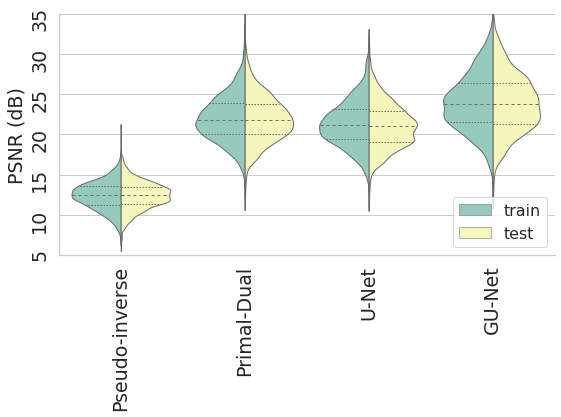

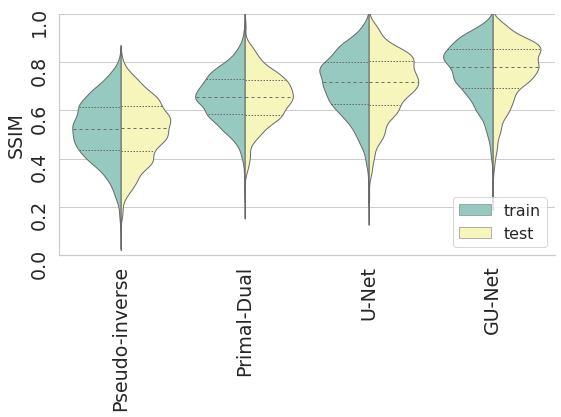

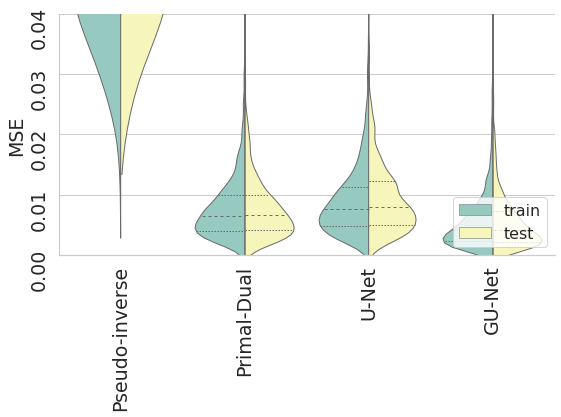

In [18]:
sns.set_context("notebook", font_scale=1.1)
plot_statistics(statistics, metrics, save_base = "./plots/COCO_violin", ylims=[[5,35], [0.,1], [0, 0.04]])#, order=["PseudoInverse", "PD", "UNet", "GUnet"])

In [19]:
operator = "NUFFT_SPIDER"

true = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB.npy")

res = [true[:5]]
titles = ["True"]

for name, network, post in results:
    try:
        ims = np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}.npy")
        res.append(ims[:5])
        titles.append(name)
    except:
        pass

In [20]:
def compare_single(images, ncols=None, nrows=None, titles=None, same_scale=False, colorbar=False, cmap='viridis', save_base="./plots/example", post_fix=''):
    """[summary]
    TODO add colorbars
    Args:
        images ([type]): [description]
        ncols ([type], optional): [description]. Defaults to None.
        nrows ([type], optional): [description]. Defaults to None.
        titles ([type], optional): [description]. Defaults to None.
        same_scale (bool, optional): [description]. Defaults to False.
    """

    if not nrows:
        nrows = 1
    if not ncols:
        ncols = 1
    if ncols*nrows < len(images):
        ncols = len(images)
        nrows = 1
    if not titles:
        titles = [""]*len(images)

    for i in range(len(images)):
        plt.figure(figsize=(6,6))
        if i == 0:
            a = plt.imshow(images[0], cmap = cmap, vmin=0, vmax=1)    #todo remove hardcoded 0,1
            vmin, vmax = a.get_clim()
        elif same_scale:
            im = plt.imshow(images[i], vmin=vmin, vmax=vmax, cmap=cmap)
        else:
            im = plt.imshow(images[i], cmap=cmap)
        if i != 0:
            plt.title(titles[i] + f" (PSNR: {peak_signal_noise_ratio(images[0], images[i]):.2f}dB)" ) 
        else:
            plt.title(titles[i])
        if colorbar:
            plt.colorbar(fraction=0.046, pad=0.04)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig(save_base + f"_{titles[i].split(' ')[0]}{post_fix}.pdf", transparent=True)
        plt.clf()
#         plt.show()

In [21]:
def compare_multiple(images, ncols=None, nrows=None, titles=None, same_scale=False, colorbar=False, cmap='viridis', save_base="./plots/example", cbar_anchor=1.2, rot=0, vmin=None, vmax=None):
    """[summary]
    TODO add colorbars
    Args:
        images ([type]): [description]
        ncols ([type], optional): [description]. Defaults to None.
        nrows ([type], optional): [description]. Defaults to None.
        titles ([type], optional): [description]. Defaults to None.
        same_scale (bool, optional): [description]. Defaults to False.
    """

    if not nrows:
        nrows = 1
    if not ncols:
        ncols = 1
    if ncols*nrows < len(images):
        ncols = len(images)
        nrows = 1
    if not titles:
        titles = [""]*len(images)
    
    images = [np.rot90(i, rot) for i in images]
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
        figsize=(ncols*6, nrows*6 +1), squeeze=False)

    a = ax[0,0].imshow(images[0])    
    ax[0,0].set_title(titles[0])
    if vmin is None:
        vmin, vmax = a.get_clim()
    for i in range(0, nrows):
        for j in range(ncols):
            if i +j*nrows >= len(images):
                break
            if same_scale:
                im = ax[i,j].imshow(images[j + i*ncols], 
                    vmin=vmin, vmax=vmax, cmap=cmap)
            else:
                im = ax[i,j].imshow(images[j + i*ncols], cmap=cmap)
            if j % ncols != 0:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] + f"\n(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                else:
                    ax[i,j].set_title(f"(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                    
            else:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] +"\n")
                else:
                    ax[i,j].set_title(titles[j + i*ncols])
                    
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
    if colorbar:
        plt.colorbar(im, ax=ax, anchor=(cbar_anchor,.50), shrink=.88)
    plt.subplots_adjust(wspace=.01)

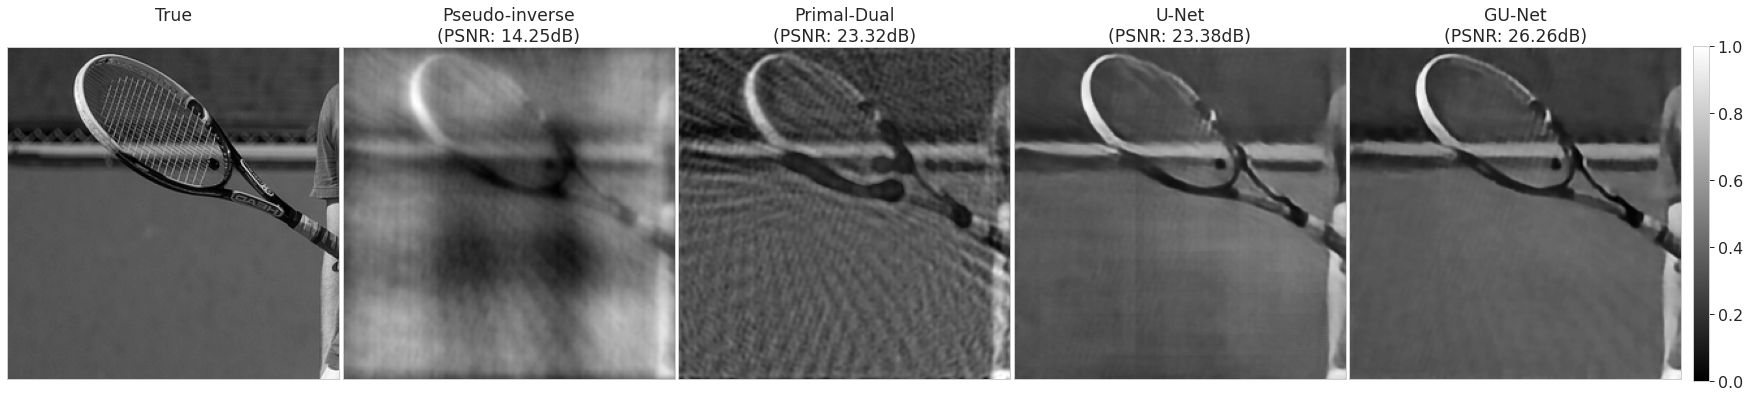

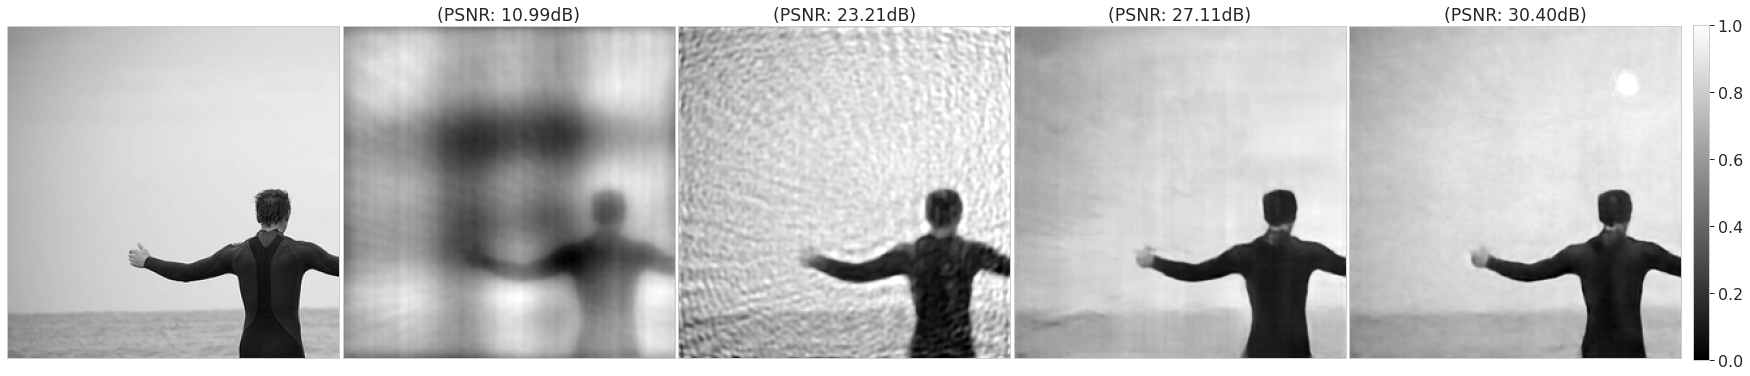

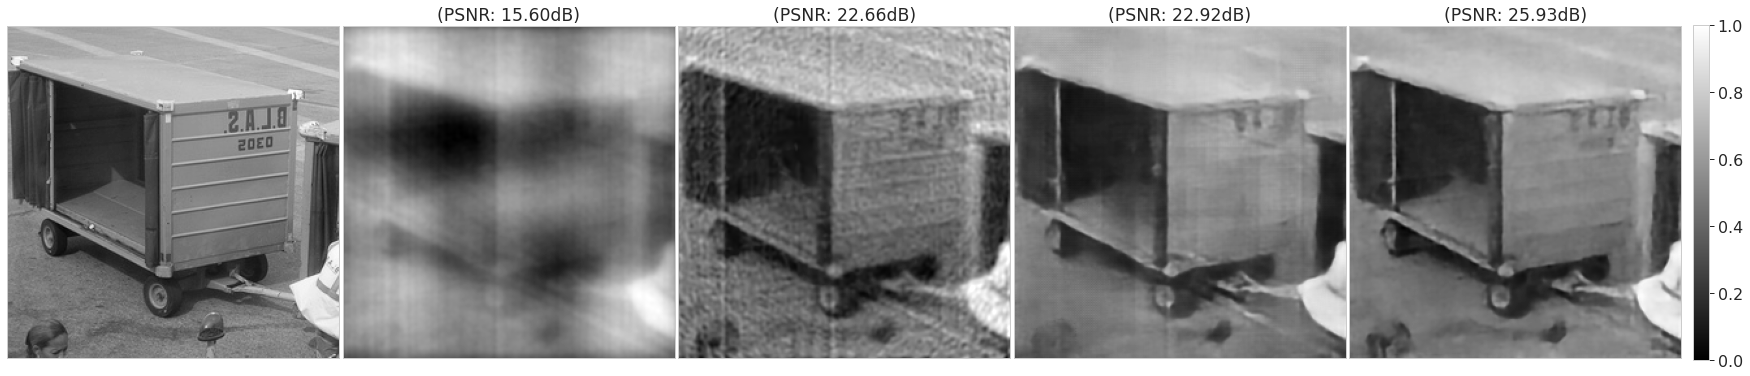

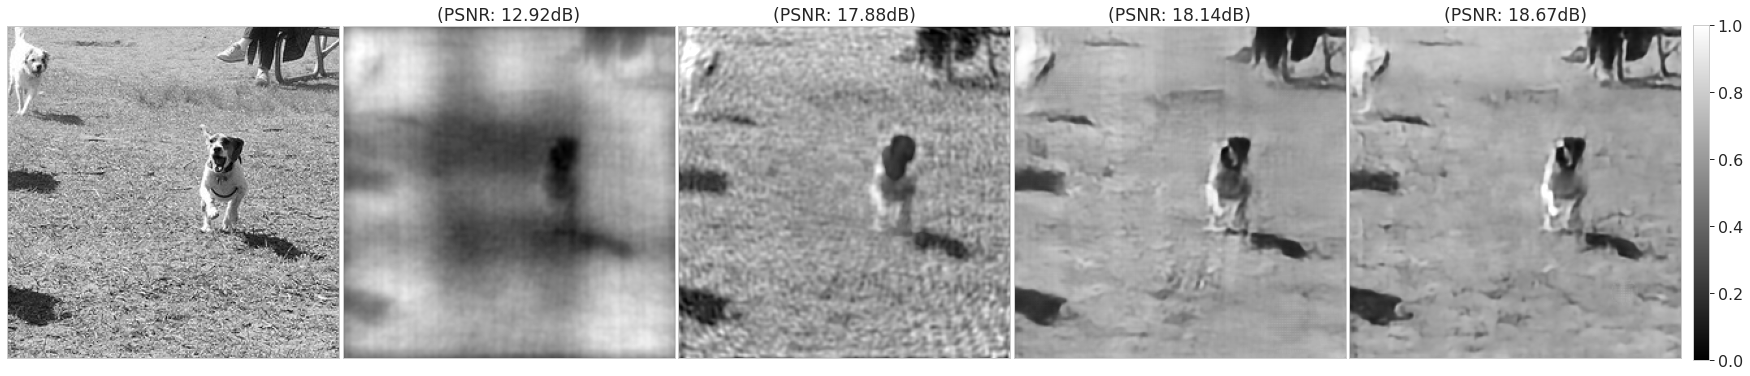

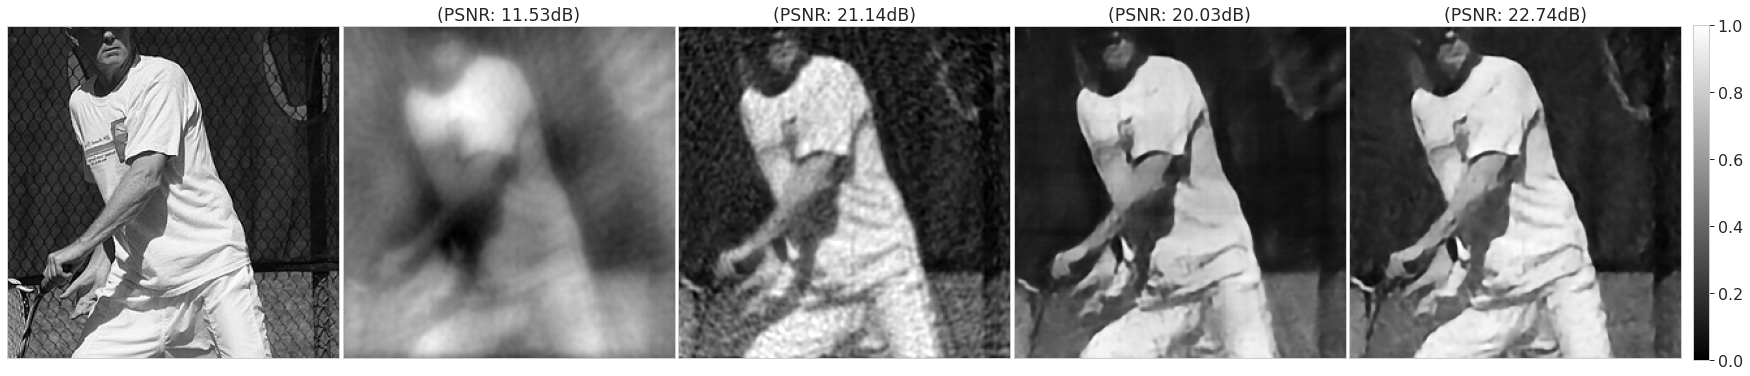

In [22]:
sns.set_context('paper', font_scale=1.8)
compare_multiple(np.array(res)[:,0], titles=titles, rot=2, nrows=1, ncols=3, colorbar=True, cbar_anchor=1 + .2/5*3, same_scale=True, vmin=0, vmax=1, cmap="gray")
plt.savefig("./plots/examples_COCO_0.pdf")

rotations = [0, 2, 0, 0]
for i in range(1,5):
    sns.set_context('paper', font_scale=1.8)
    compare_multiple(np.array(res)[:,i], rot=rotations[i-1], nrows=1, ncols=3, colorbar=True, cbar_anchor=1 + .2/5*3, same_scale=True, vmin=0, vmax=1, cmap="gray")
    plt.savefig(f"./plots/examples_COCO_{i}.pdf")


In [23]:
for i in range(5):
    compare_single(np.array(res)[:,i], titles=titles, nrows=3, ncols=3, colorbar=True, same_scale=True, cmap="gray", save_base="./plots/example_COCO", post_fix=f'_{i}')

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

# Computation times

In [24]:
begin = True
for name, net, post in results:
#     print(name, net, post)
    try: 
        summary = np.loadtxt(f"./results/COCO/{operator}/summary_{net}{post}.csv", delimiter=',', dtype=str)
        if begin:
            begin = False
            print(f"{'Name':25} & {summary[0,0] +' (ms)':20} & {summary[2,0]:20} & {summary[3,0]:20} & {summary[4,0]:20} \\\\")
        values = summary[:,1].astype(float)
        print(f"{name:25}& ${values[0]*1e3:8.3f} \pm {values[1]*1e3:<7.3f}$ & ${values[2]:20.0f}$ & ${values[3]:20.0f}$ & ${values[4]:20.0f}$ \\\\")
    except:
        pass
    
print(f"{'PD':25}& ${54.63289585908254*1e3:8.3e} \pm {5.557309727343783*1e3:<7.3e}$ & ${0:20.0f}$ & ${0:20.0f}$ & ${0:20.0f}$ \\\\")


Name                      & Mean time (ms)       & Total params         & Trainable params     & Non-trainable params \\
Pseudo-inverse           & $   0.365 \pm 36.753 $ & $                   0$ & $                   0$ & $                   0$ \\
U-Net                    & $   1.411 \pm 20.815 $ & $             2167649$ & $             2164193$ & $                3456$ \\
GU-Net                   & $   6.064 \pm 536.018$ & $             2575521$ & $             2572065$ & $                3456$ \\
PD                       & $5.463e+04 \pm 5.557e+03$ & $                   0$ & $                   0$ & $                   0$ \\


In [25]:
a  = np.load("./data/processed/TNG/NUFFT_SPIDER/times_train_30dB.npy")

In [26]:
a.min()

41.988266468048096

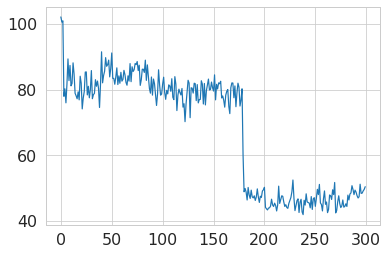

In [27]:
plt.plot(a)

In [28]:
np.median(a)

77.38123989105225

In [29]:
np.std(a)

17.548024501884633

# Robustness

In [30]:
operator = "NUFFT_SPIDER"

# results = []
# results += [(name, "Test", f"./data/processed/{data}/{operator}/test_predict_{net}_robustness{post}.npy") for name, net, post in name_net_post]

statistics = pd.DataFrame(columns=["PSNR", "SSIM", "MSE", "method", "set"])#{}

sigmas = np.repeat(np.arange(30,5,-2.5), 100)
x_test = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB_robustness.npy").reshape(-1,256,256)

for name, network, post in results:
# for j in tqdm.tqdm(range(1)):

    try:
        print(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}_robustness.npy")
        pred = np.squeeze( np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}_robustness.npy") )
        sigmas = sigmas.flatten()
        df = pd.DataFrame()
        for metric, f in metrics:
            x = x_test
            df[metric] = [f(x[i], pred[i]) for i in range(len(x))]
            df['Method'] = name
            df['Noise'] = sigmas
#             print(df)
        if statistics.empty:
            statistics = df
        else:
            statistics = statistics.append(df, ignore_index=False)
    #         examples.append((name, dset, pred[0]))
    except:
        pass


./data/processed/COCO/NUFFT_SPIDER/test_predict_PseudoInverse_30dB_robustness.npy
./data/processed/COCO/NUFFT_SPIDER/test_predict_PD_30dB_robustness.npy
./data/processed/COCO/NUFFT_SPIDER/test_predict_UNet_30dB_robustness.npy
./data/processed/COCO/NUFFT_SPIDER/test_predict_GUnet_30dB_robustness.npy


In [31]:
statistics_robustness = statistics

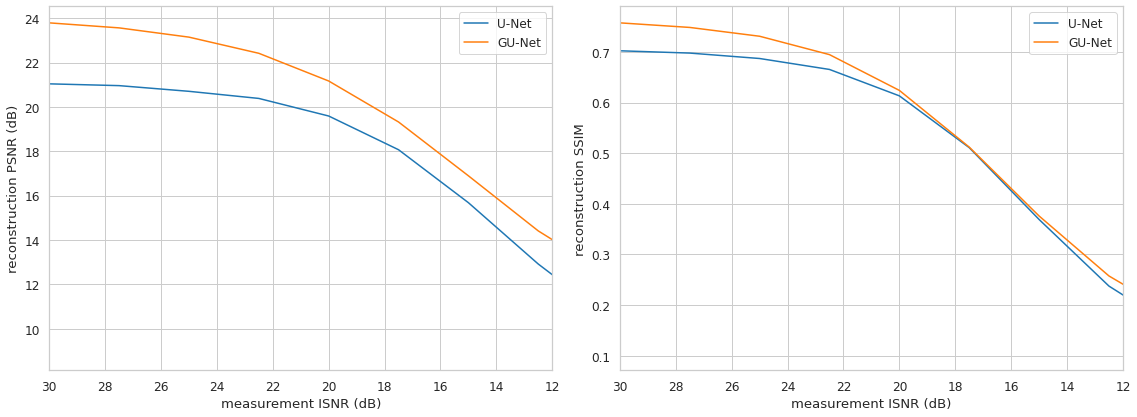

In [32]:
sns.set_context("notebook", font_scale=1.1)

fig, ax = plt.subplots(ncols=2, figsize=(16,6))

# plt.figure(figsize=(12,8))
i = 0
for name, network, post in results:
#     print(name, mode)
    mode = "Train"
    if mode == "Train":
        if True:
            sub = statistics_robustness[ statistics_robustness["Method"] ==  name].groupby("Noise").mean()
            std = statistics_robustness[ statistics_robustness["Method"] ==  name].groupby("Noise").std()
            
            if len(sub > 0) and name != 'Adjoint':
                ax[0].plot(np.arange(7.5, 32.5, 2.5), sub['PSNR'].values, color=f"C{i}", label = name)
#                 ax[0].fill_between(np.arange(7.5, 32.5, 2.5), sub['PSNR'].values-std['PSNR'].values, sub['PSNR'].values+std['PSNR'].values, color=f"C{i}", alpha=.3)

                ax[1].plot(np.arange(7.5, 32.5, 2.5), sub['SSIM'].values, color=f"C{i}", label = name)
#                 ax[1].fill_between(np.arange(7.5, 32.5, 2.5), sub['SSIM'].values-std['SSIM'].values, sub['SSIM'].values+std['SSIM'].values, color=f"C{i}", alpha=.3)
                i+= 1
                
#                 ax2 = ax[0].twiny()
#                 ax2.axis(xmin=fs.max(), xmax=fs.min())
#                 ax2.set_xticks(fs[::-1])
ax[0].axis(xmin=30, xmax=12)
ax[1].axis(xmin=30, xmax=12)
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel("measurement ISNR (dB)")
ax[0].set_ylabel("reconstruction PSNR (dB)")
ax[1].set_xlabel("measurement ISNR (dB)")
ax[1].set_ylabel("reconstruction SSIM")
plt.tight_layout()
plt.savefig("./plots/robustness.pdf")

some examples of predictions at different noise levels (using the last network which is the HL-net)

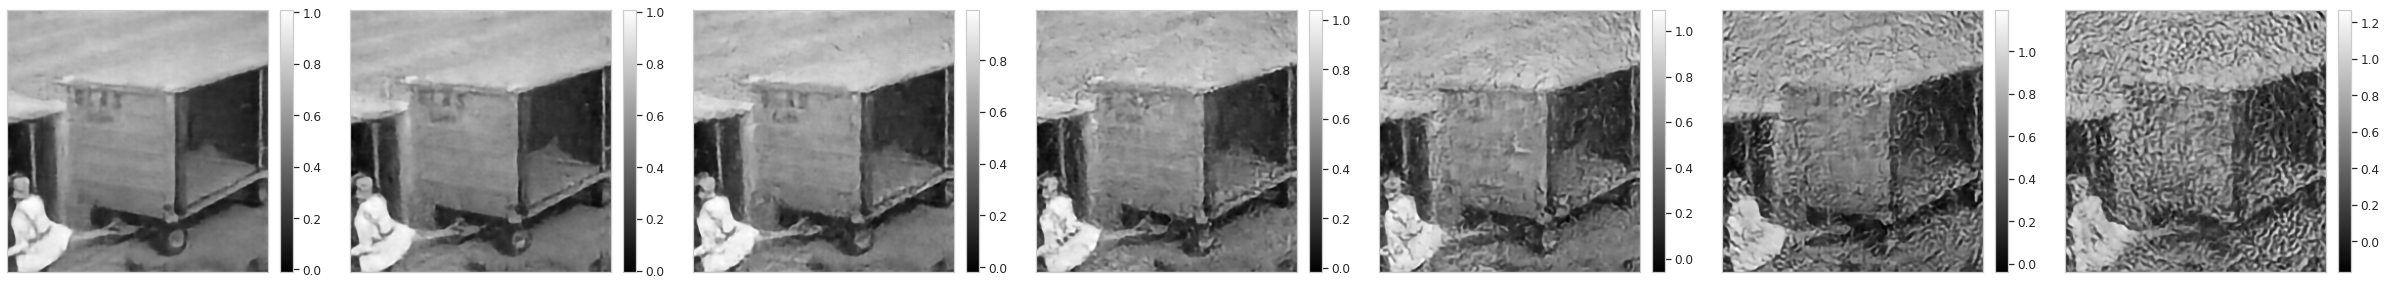

In [33]:
i = 2
compare([pred[i+j] for j in np.arange(0,700, 100)], ncols=2, colorbar=True, cmap='gray')

# Transfer learning TNG

In [63]:
data = "TNG"
operator="NUFFT_SPIDER"

In [35]:
results = [
#     ("Pseudo-Inverse", "PseudoInverse", "_TNG"),
    ("Primal-Dual", "PD", ""),
#     (f"{data}", "UNet", f"_{data}"),
#     ("COCO", "UNet", "_COCO"),
    ("U-Net", "UNet", "_transfer"),
    
#     (f"{data}", "GUnet", f"_{data}"),
#     ("COCO", "GUnet", "_COCO"),
    ("GU-Net", "GUnet", "_transfer"),


]

In [36]:
 [(j+f" {operator} {k[1:]}", "test", k) for i,j,k in results]

[('PD NUFFT_SPIDER ', 'test', ''),
 ('UNet NUFFT_SPIDER transfer', 'test', '_transfer'),
 ('GUnet NUFFT_SPIDER transfer', 'test', '_transfer')]

Name                                    |PSNR                |SSIM                |MSE                 |
GUnet_train                             |  37.060 \pm   2.181|   0.932 \pm   0.020|   0.000 \pm   0.000|
PD_train                                |  36.580 \pm   2.157|   0.939 \pm   0.027|   0.000 \pm   0.000|
UNet_train                              |  36.454 \pm   1.315|   0.934 \pm   0.019|   0.000 \pm   0.000|
Name                                    |PSNR                |SSIM                |MSE                 |
GUnet_test                              |  36.313 \pm   2.735|   0.924 \pm   0.023|   0.000 \pm   0.000|
PD_test                                 |  36.282 \pm   2.480|   0.934 \pm   0.033|   0.000 \pm   0.000|
UNet_test                               |  33.141 \pm   2.644|   0.925 \pm   0.023|   0.001 \pm   0.000|


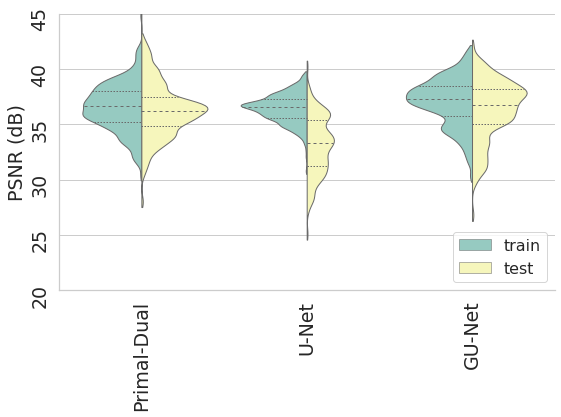

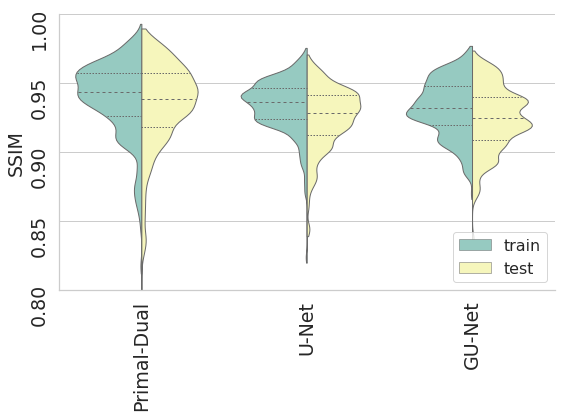

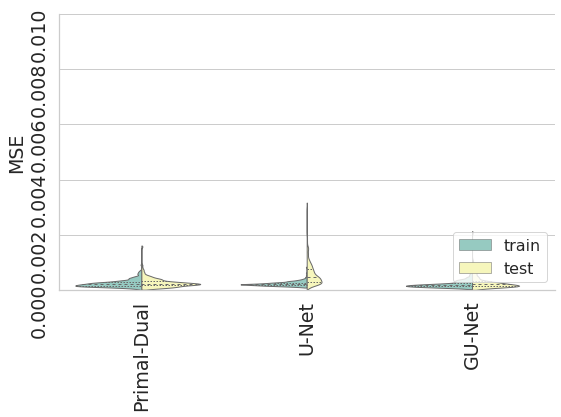

In [37]:
sns.set_context("notebook", font_scale=1.1)
for operator in ["NUFFT_SPIDER"]:
    statistics = pd.DataFrame(columns=["PSNR", "SSIM", "MSE", "Method", "Set"])

    for name, network, post in results:
        try:
            df = pd.read_csv(f"./results/{data}/{operator}/statistics_{network}_30dB{post}.csv")
            df["name"] = name
            if statistics.empty:
                statistics = df
            else:
                statistics = statistics.append(df, ignore_index=False)
        except:
            pass
    with pd.option_context('mode.use_inf_as_na', True):
        statistics.dropna(inplace=True)
    statistics.Method = statistics.Method.map(lambda x: x.split(" ")[0])
    print_statistics(statistics, [(j, "train", k) for i,j,k in results], metrics)
    print_statistics(statistics, [(j, "test", k) for i,j,k in results], metrics)
    plot_statistics(statistics, metrics, ylims=[[20,45], [0.8,1], [0, 0.01]], save_base="./plots/violin_TNG")#, order=["Pseudo-inverse", "Primal Dual", "U-net", "GU-net"])

In [64]:
results = [
    ("PseudoInverse", "PseudoInverse", f"_{data}"),
    
    ("Primal-Dual", "PD", ""),

    
#     (f"UNet_{data}", "UNet", f"_{data}"),
#     ("UNet_COCO", "UNet", "_COCO"),
    ("UNet_Transfer", "UNet", "_transfer"),
    
#     (f"GUnet_{data}", "GUnet", f"_{data}"),
#     ("GUnet_COCO", "GUnet", "_COCO"),
    ("GUnet_Transfer", "GUnet", "_transfer"),
]

In [65]:
operator = "NUFFT_SPIDER"

true_tng = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB.npy")

res_tng = [true_tng[:5]]
titles_tng = ["True"]

for name, network, post in results:
    try:
        ims = np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}.npy")
        res_tng.append(ims[:5])
        titles_tng.append(name)
    except:
        pass
titles_tng = [" ".join(t.split("_")) for t in titles_tng]

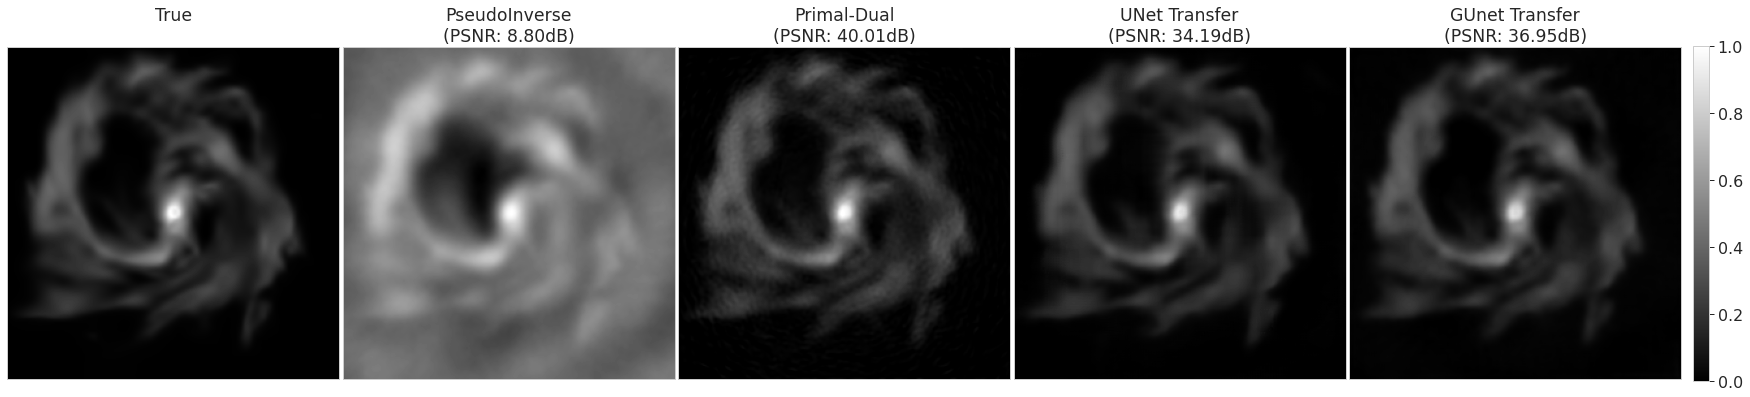

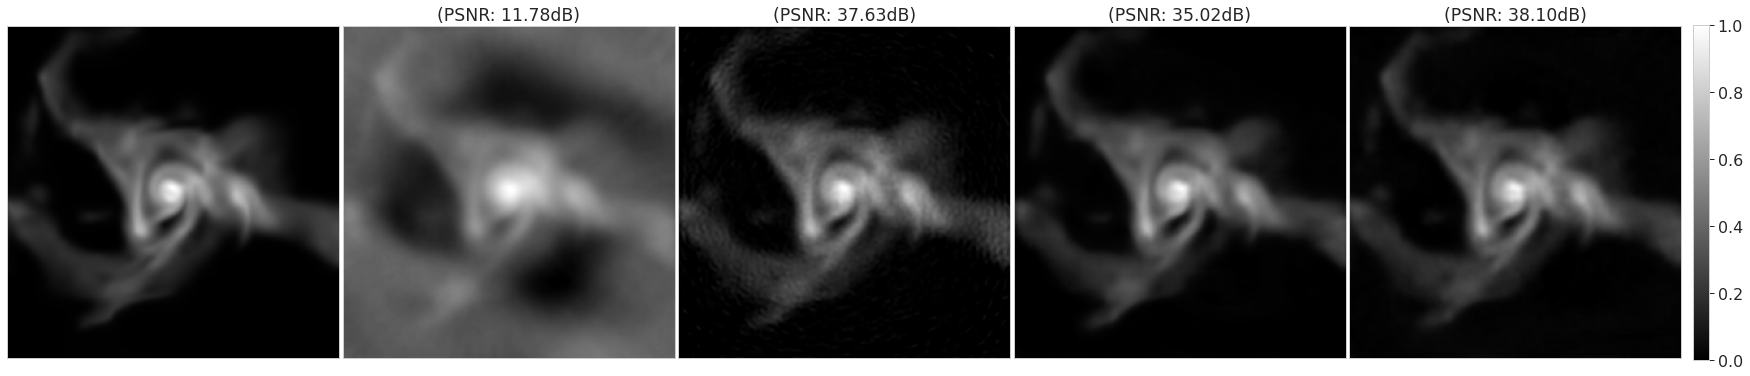

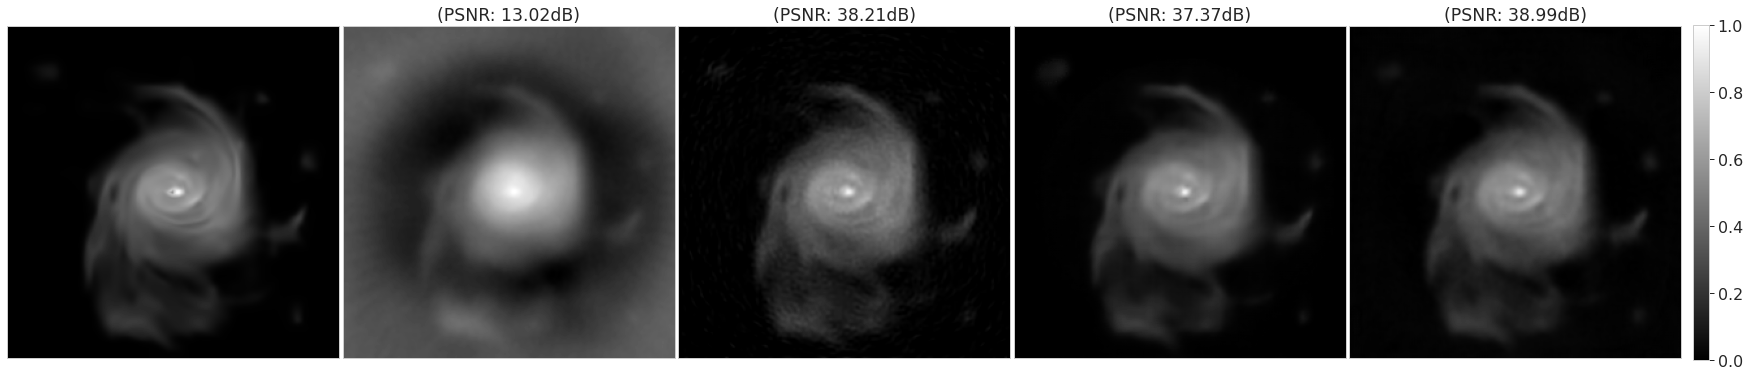

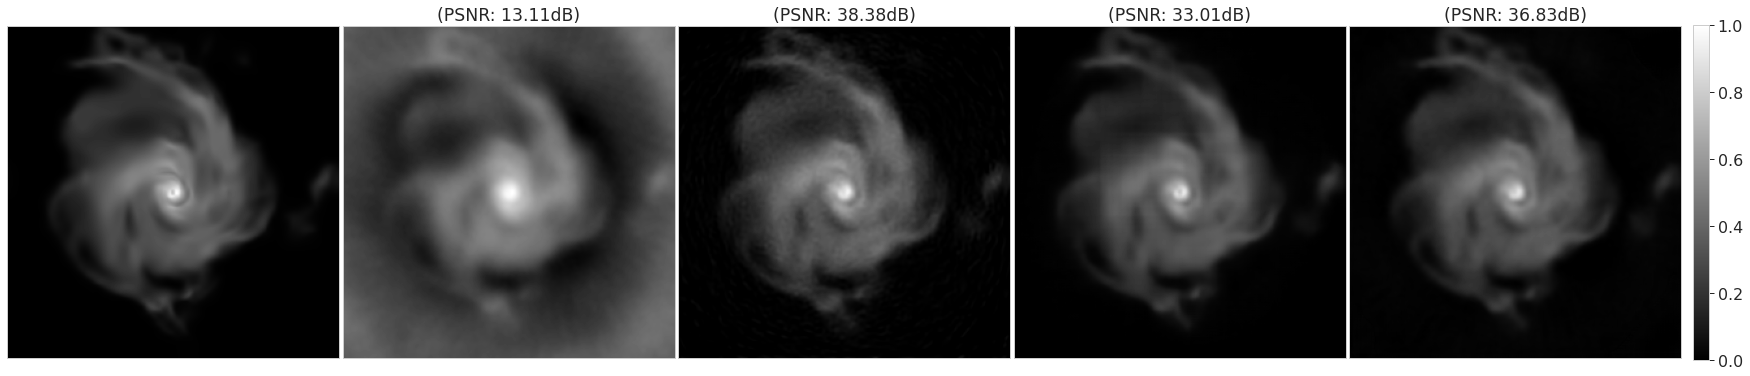

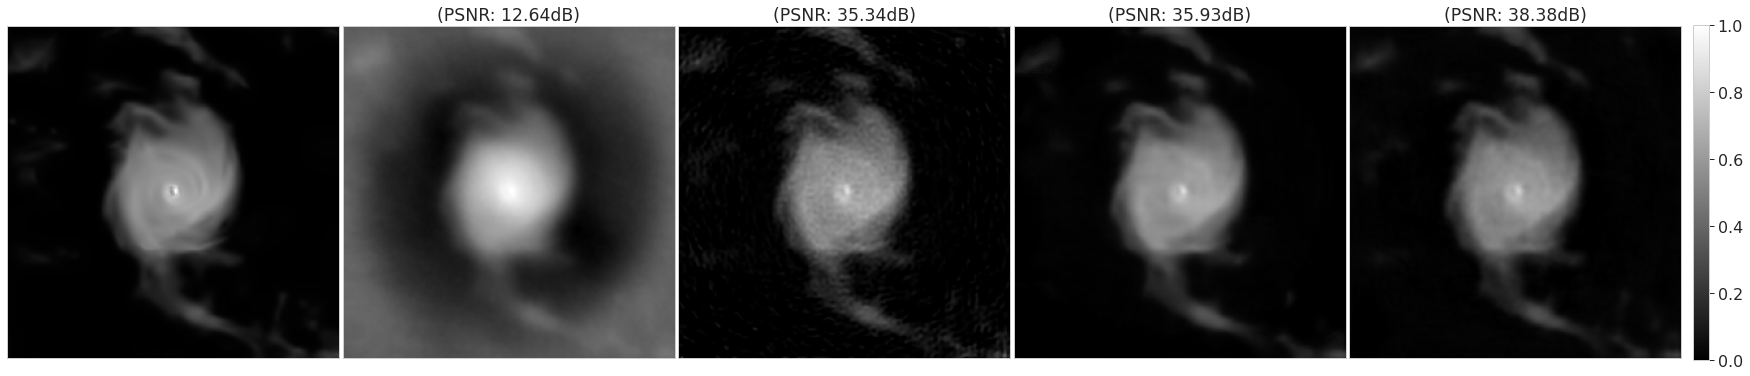

In [66]:
sns.set_context('paper', font_scale=1.8)
compare_multiple(np.array(res_tng)[:,0], titles=titles_tng, nrows=1, ncols=3, colorbar=True, cbar_anchor=1 + .2/5*3, same_scale=True, cmap="gray", vmin=0, vmax=1)
plt.savefig(f"./plots/examples_{data}_0.pdf")

for i in range(1,5):
    sns.set_context('paper', font_scale=1.8)
    compare_multiple(np.array(res_tng)[:,i], nrows=1, ncols=3, colorbar=True, cbar_anchor=1 + .2/5*3, same_scale=True, cmap="gray", vmin=0, vmax=1)
    plt.savefig(f"./plots/examples_{data}_{i}.pdf")


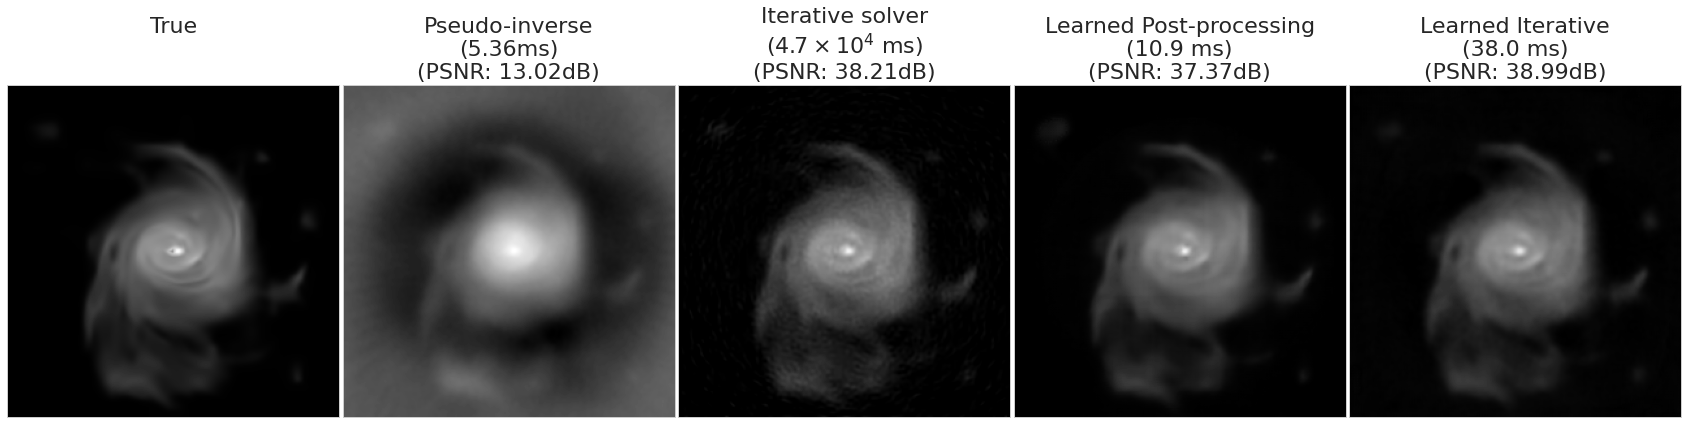

In [44]:
results = [
#     ("PseudoInverse", "PseudoInverse", f"_{data}"),
    
    (f"GUnet_{data}", "GUnet", f"_{data}"),
    ("GUnet_COCO", "GUnet", "_COCO"),
    ("GUnet_Transfer", "GUnet", "_transfer"),
]

In [60]:
operator = "NUFFT_SPIDER"

true_tng = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB.npy")

res_tng = [true_tng[:5]]
titles_tng = ["True"]

for name, network, post in results:
    try:
        ims = np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}.npy")
        res_tng.append(ims[:5])
        titles_tng.append(name)
    except:
        pass
titles_tng = [" ".join(t.split("_")) for t in titles_tng]

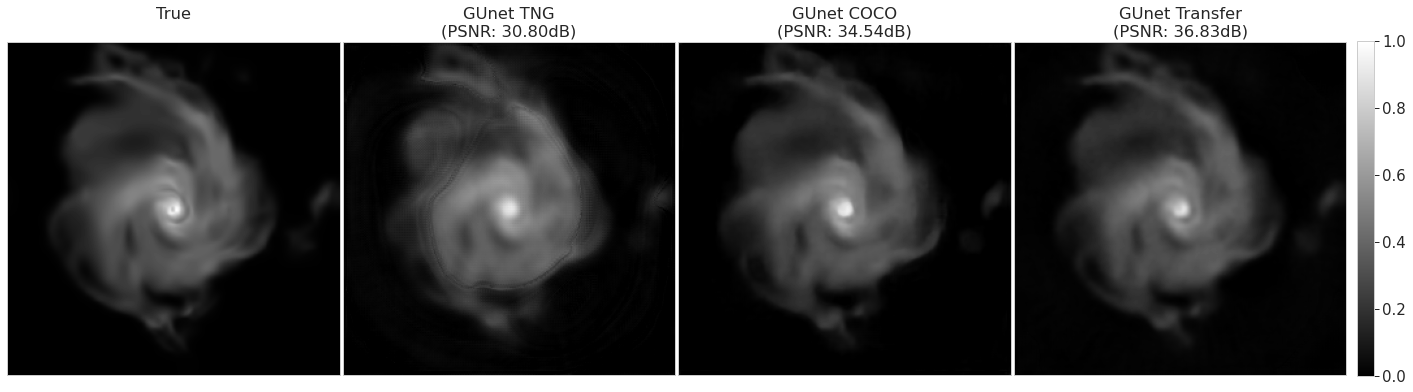

In [46]:
sns.set_context('paper', font_scale=1.7)
compare_multiple(np.array(res_tng)[:,3], titles=titles_tng, nrows=1, ncols=3, colorbar=True, cbar_anchor=1 + .2/4*3, same_scale=True, cmap="gray", vmin=0, vmax=1)
plt.savefig(f"./plots/examples_{data}_transfer.pdf")

In [47]:
operator = "NUFFT_SPIDER"

true_tng = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB.npy")

res_tng = [true_tng[:5]]
titles_tng = ["True"]

for name, network, post in results:
    try:
        ims = np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}.npy")
        res_tng.append(ims[:5])
        titles_tng.append(name)
    except:
        pass

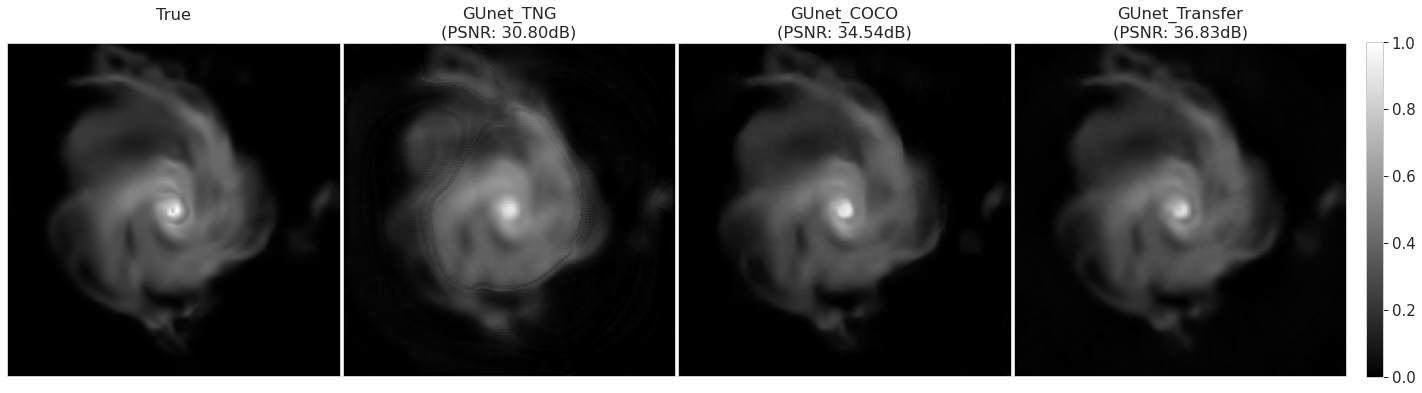

In [48]:
i = 3
compare_multiple([res_tng[0][i], res_tng[-3][i], res_tng[-2][i], res_tng[-1][i]], 
               titles=[titles_tng[0], titles_tng[-3], titles_tng[-2], titles_tng[-1]],
               same_scale=True, colorbar=True, cmap="gray", save_base="./plots/examples_TNG")

In [49]:
for i in range(5):
    compare_single(np.array(res_tng)[:,i], titles=titles_tng, nrows=3, ncols=3, colorbar=True, same_scale=True, cmap="gray", save_base="./plots/example_TNG", post_fix=f"_{i}")

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

# SATS

In [50]:
data = "SATS"
operator="NUFFT_SPIDER"

In [51]:
results = [
#     ("PseudoInverse", "PseudoInverse", f"_{data}"),

    ("Primal-Dual", "PD", ""),

    
#     (f"{data}", "UNet", f"_{data}"),
#     ("COCO", "UNet", "_COCO"),
    ("U-Net", "UNet", "_transfer"),
    
#     (f"{data}", "GUnet", f"_{data}"),
#     ("COCO", "GUnet", "_COCO"),
    ("GU-Net", "GUnet", "_transfer"),


]

In [52]:
 [(j+f" {operator} {k[1:]}", "test", k) for i,j,k in results]

[('PD NUFFT_SPIDER ', 'test', ''),
 ('UNet NUFFT_SPIDER transfer', 'test', '_transfer'),
 ('GUnet NUFFT_SPIDER transfer', 'test', '_transfer')]

Name                                     & PSNR                 & SSIM                 & MSE                  & \\
GUnet_train                              & $   27.059 \pm   2.611 $ & $    0.822 \pm   0.070 $ & $    0.002 \pm   0.002 $ & \\
PD_train                                 & $   25.874 \pm   2.522 $ & $    0.760 \pm   0.066 $ & $    0.003 \pm   0.002 $ & \\
UNet_train                               & $   26.199 \pm   3.114 $ & $    0.795 \pm   0.082 $ & $    0.003 \pm   0.003 $ & \\
Name                                     & PSNR                 & SSIM                 & MSE                  & \\
GUnet_test                               & $   26.913 \pm   2.949 $ & $    0.819 \pm   0.077 $ & $    0.003 \pm   0.002 $ & \\
PD_test                                  & $   25.735 \pm   2.798 $ & $    0.757 \pm   0.072 $ & $    0.003 \pm   0.002 $ & \\
UNet_test                                & $   26.202 \pm   3.612 $ & $    0.791 \pm   0.092 $ & $    0.003 \pm   0.003 $ & \\


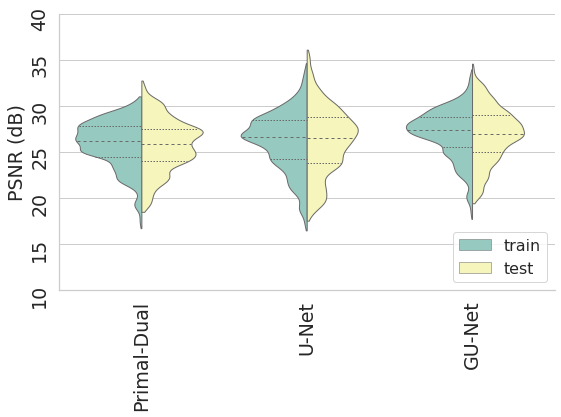

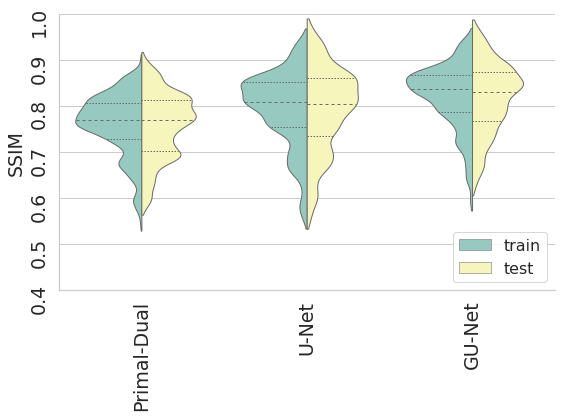

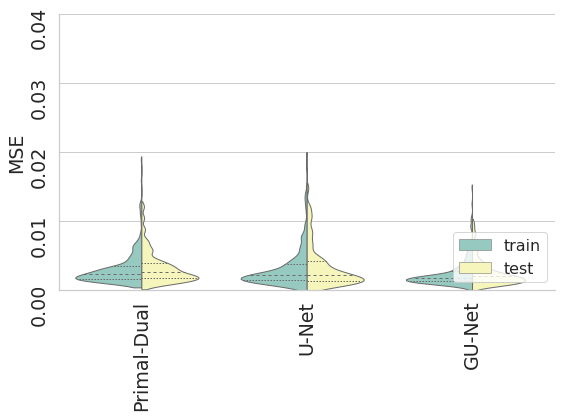

In [53]:
sns.set_context("notebook", font_scale=1.1)
for operator in ["NUFFT_SPIDER"]:
    statistics = pd.DataFrame(columns=["PSNR", "SSIM", "MSE", "Method", "Set"])

    for name, network, post in results:
        try:
            df = pd.read_csv(f"./results/{data}/{operator}/statistics_{network}_30dB{post}.csv")
            df['name'] = name
            if statistics.empty:
                statistics = df
            else:
                statistics = statistics.append(df, ignore_index=False)
        except:
            pass
    with pd.option_context('mode.use_inf_as_na', True):
        statistics.dropna(inplace=True)
    statistics.Method = statistics.Method.map(lambda x: x.split(" ")[0])

    print_statistics(statistics, [(j, "train", k) for i,j,k in results], metrics, latex=True)
    print_statistics(statistics, [(j, "test", k) for i,j,k in results], metrics, latex=True)
    plot_statistics(statistics, metrics, ylims=[[10,40], [0.4,1], [0, 0.04]], save_base="./plots/violin_SATS")#, order=["Pseudo-inverse", "Primal Dual", "U-net", "GU-net"])

In [54]:
set(list(statistics.Method))

{'GUnet', 'PD', 'UNet'}

In [55]:
results = [
    ("PseudoInverse", "PseudoInverse", f"_{data}"),
    
    ("Primal-Dual", "PD", ""),

    
#     (f"UNet {data}", "UNet", f"_{data}"),
#     ("UNet COCO", "UNet", "_COCO"),
    ("U-Net", "UNet", "_transfer"),
    
#     (f"GUnet {data}", "GUnet", f"_{data}"),
#     ("GUnet COCO", "GUnet", "_COCO"),
    ("GU-Net", "GUnet", "_transfer"),
]

In [56]:
operator = "NUFFT_SPIDER"

true_sats = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB.npy")

res_sats = [true_sats[:5]]
titles_sats = ["True"]

for name, network, post in results:
    try:
        ims = np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}.npy")
        res_sats.append(ims[:5])
        titles_sats.append(name.split(" ")[0])
    except:
        pass
titles_sats = [" ".join(t.split("_")) for t in titles_sats]

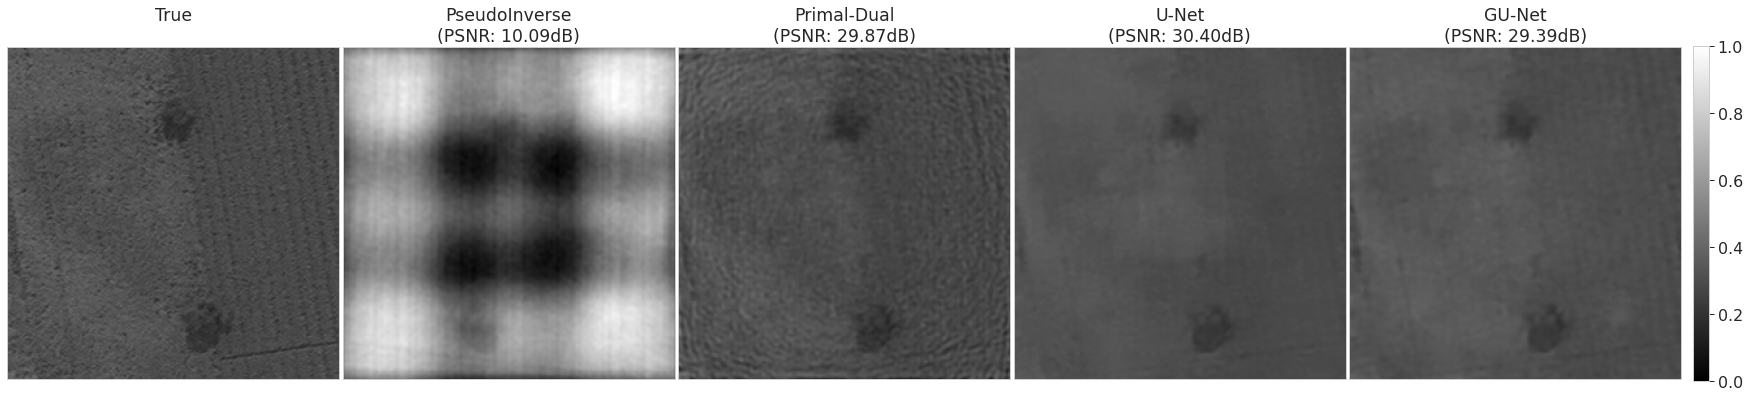

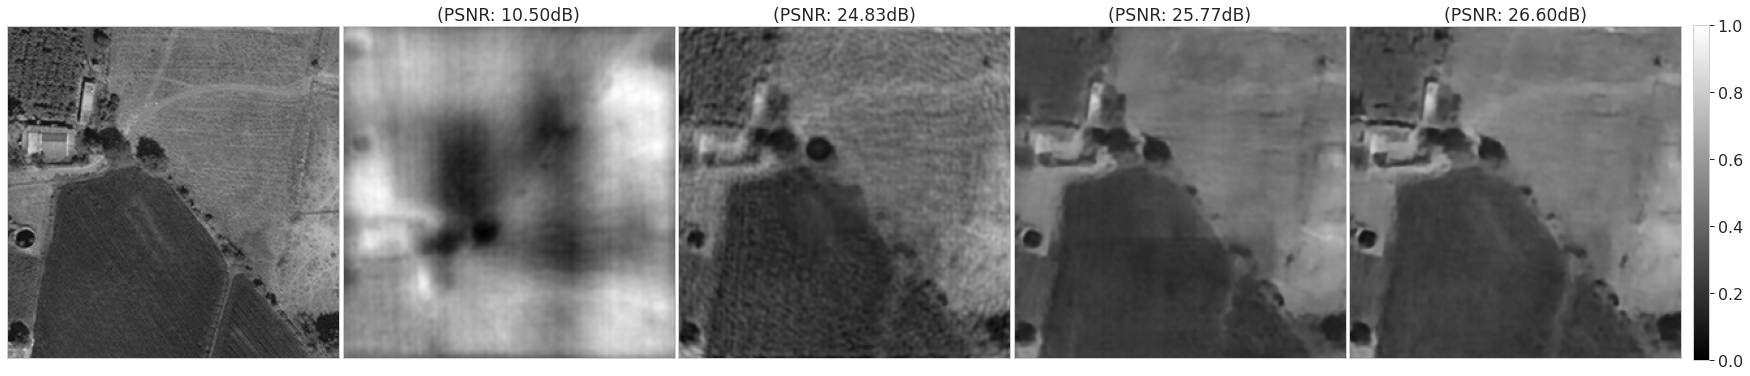

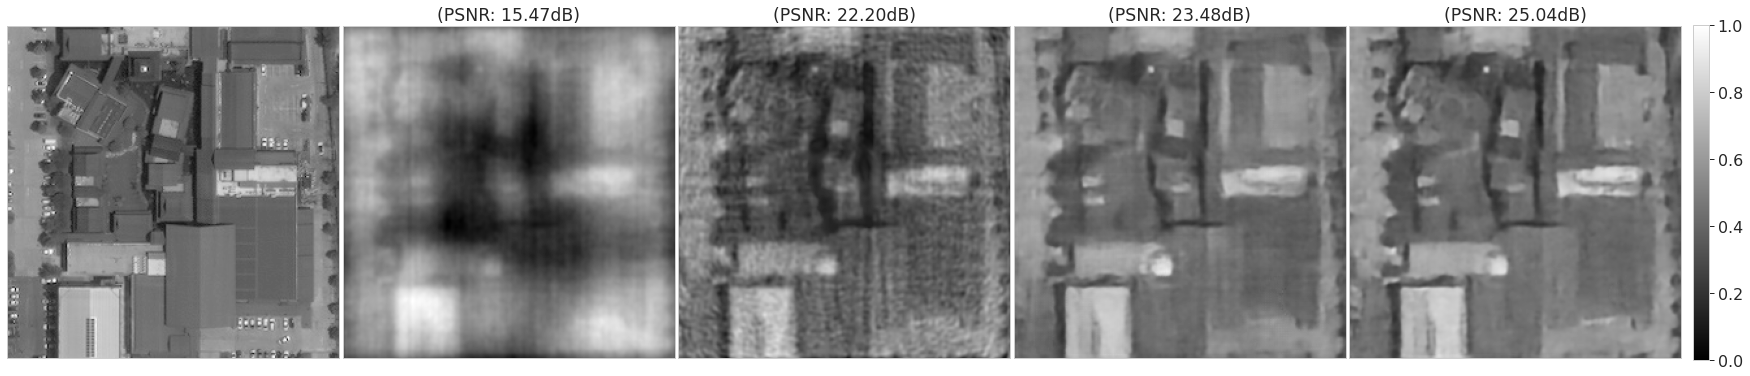

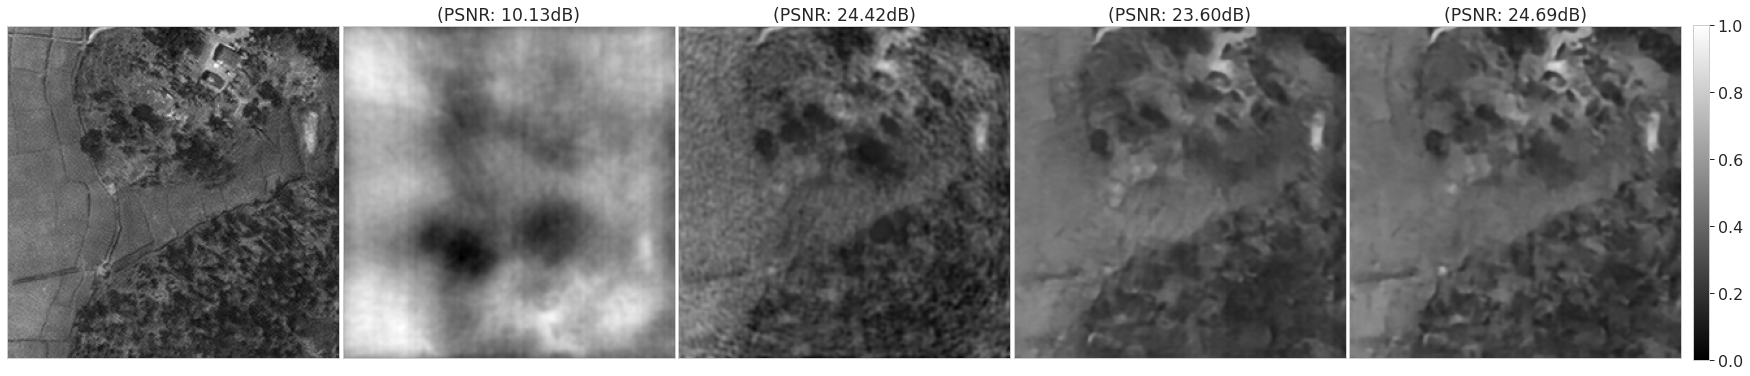

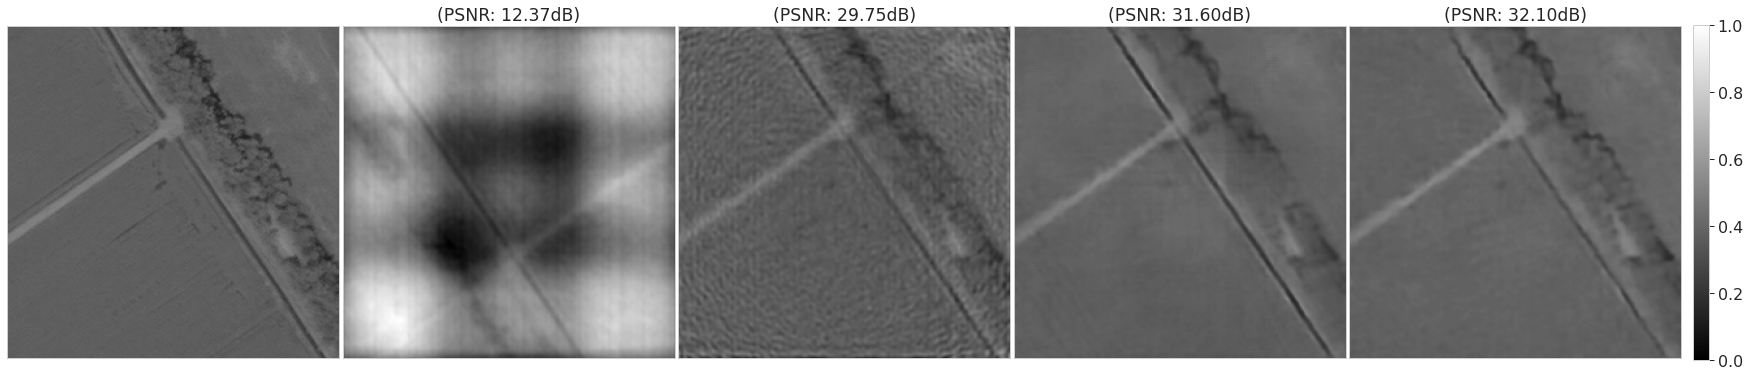

In [57]:
sns.set_context('paper', font_scale=1.8)
compare_multiple(np.array(res_sats)[:,0], titles=titles_sats, nrows=1, ncols=3, colorbar=True, cbar_anchor=1 + .2/5*3, same_scale=True, cmap="gray", vmin=0, vmax=1)
plt.savefig(f"./plots/examples_{data}_0.pdf")

for i in range(1,5):
    sns.set_context('paper', font_scale=1.8)
    compare_multiple(np.array(res_sats)[:,i], nrows=1, ncols=3, colorbar=True, cbar_anchor=1 + .2/5*3, same_scale=True, cmap="gray", vmin=0, vmax=1)
    plt.savefig(f"./plots/examples_{data}_{i}.pdf")


In [58]:
for i in range(5):
    compare_single(np.array(res_sats)[:,i], titles=titles_sats, nrows=3, ncols=3, colorbar=True, same_scale=True, cmap="gray",save_base="./plots/example_SATS", post_fix=f"_{i}")

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

# presentation/poster plots

In [87]:
def compare_multiple(images, ncols=None, nrows=None, titles=None, same_scale=False, colorbar=False, cmap='viridis', save_base="./plots/example", cbar_anchor=1.2, rot=0, vmin=None, vmax=None):
    """[summary]
    TODO add colorbars
    Args:
        images ([type]): [description]
        ncols ([type], optional): [description]. Defaults to None.
        nrows ([type], optional): [description]. Defaults to None.
        titles ([type], optional): [description]. Defaults to None.
        same_scale (bool, optional): [description]. Defaults to False.
    """

    if not nrows:
        nrows = 1
    if not ncols:
        ncols = 1
    if ncols*nrows < len(images):
        ncols = len(images)
        nrows = 1
    if not titles:
        titles = [""]*len(images)
    
    images = [np.rot90(i, rot) for i in images]
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
        figsize=(ncols*6, nrows*6 +2), squeeze=False)

    a = ax[0,0].imshow(images[0])    
    ax[0,0].set_title(titles[0])
    if vmin is None:
        vmin, vmax = a.get_clim()
    for i in range(0, nrows):
        for j in range(ncols):
            if i +j*nrows >= len(images):
                break
            if same_scale:
                im = ax[i,j].imshow(images[j + i*ncols], 
                    vmin=vmin, vmax=vmax, cmap=cmap)
            else:
                im = ax[i,j].imshow(images[j + i*ncols], cmap=cmap)
            if j % ncols != 0:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] + f"\n(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                else:
                    ax[i,j].set_title(f"(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                    
            else:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] +"\n")
                else:
                    ax[i,j].set_title(titles[j + i*ncols])
                    
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
    if colorbar:
        plt.colorbar(im, ax=ax, anchor=(cbar_anchor,0), shrink=.8)
    plt.subplots_adjust(wspace=.01)

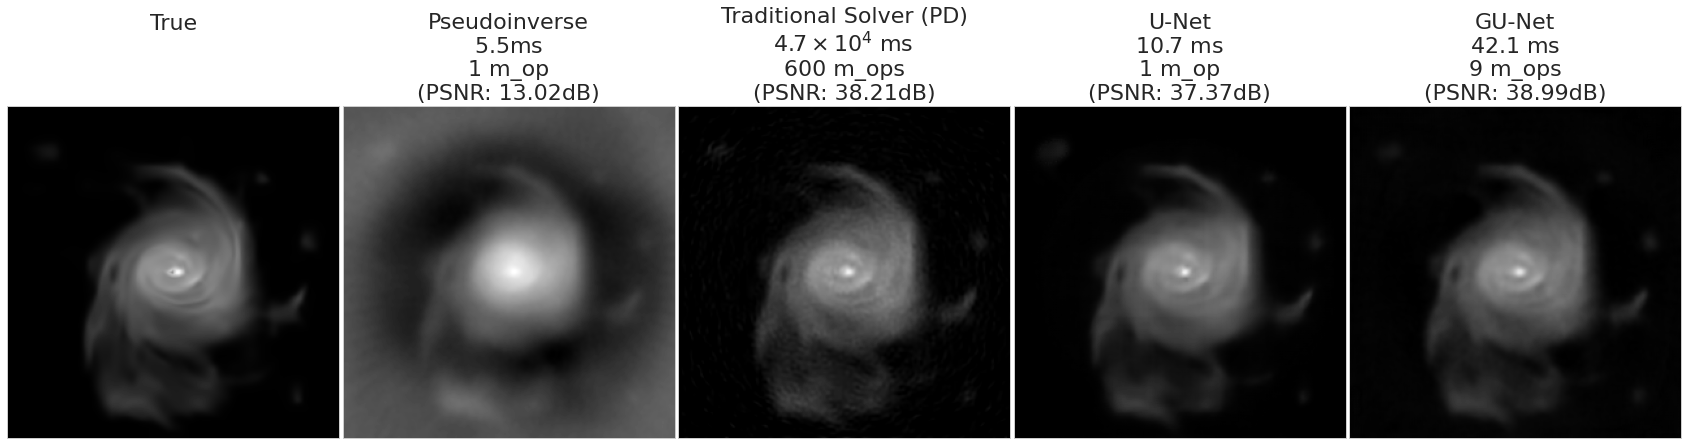

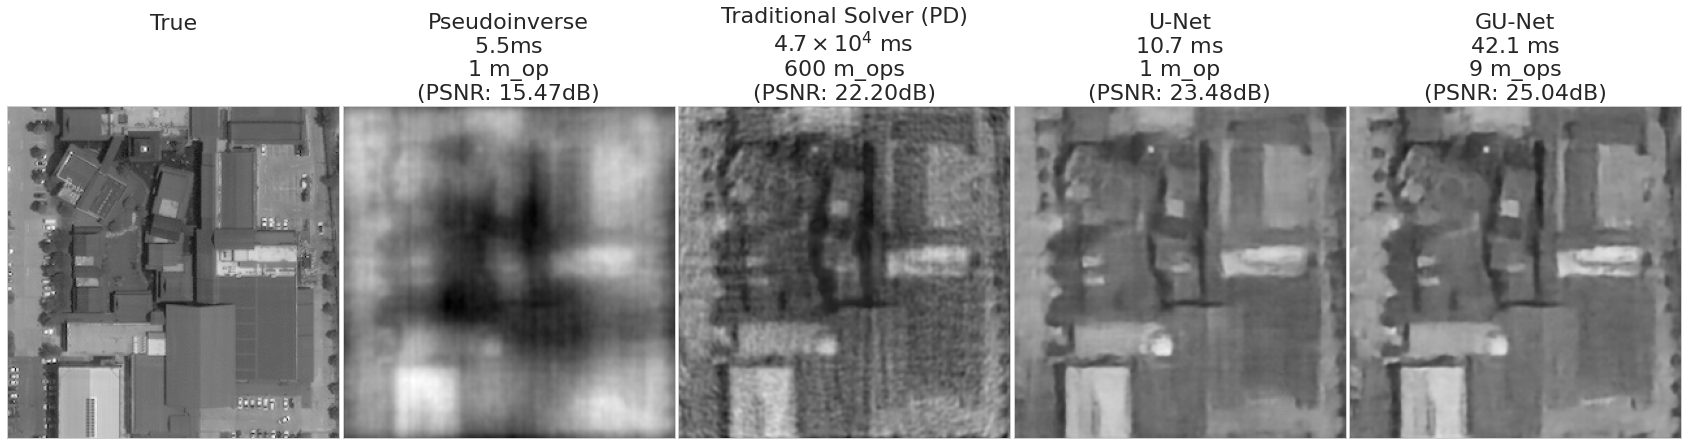

In [89]:
sns.set_context('paper', font_scale=2.3)

# titles_tng[1] += "\n(5.63 ms)"
# titles_tng[3] += "\n(10.9 ms)"
# titles_tng[4] += "\n(38.0 ms)"
# titles_tng[2] += "\n(47000 ms)"

titles_tng2 = [
    "True\n\n",
    "Pseudoinverse\n$5.5$ms\n1 m_op",
    "Traditional Solver (PD)\n" +r"$4.7 \times 10^4$ ms" +" \n600 m_ops",
    "U-Net\n$10.7$ ms\n1 m_op",
    "GU-Net\n$42.1$ ms\n9 m_ops"
    
]


compare_multiple(np.array(res_tng)[:,2], titles=titles_tng2, nrows=1, ncols=3, colorbar=False, cbar_anchor=1 + .2/5*3, same_scale=True, cmap="gray", vmin=0, vmax=1)
plt.savefig("./plots/presentation_results1.pdf", transparent=True)
compare_multiple(np.array(res_sats)[:,2], titles=titles_tng2, nrows=1, ncols=3, colorbar=False, cbar_anchor=1 + .2/5*3, same_scale=True, cmap="gray", vmin=0, vmax=1)
plt.savefig("./plots/presentation_results2.pdf", transparent=True)
